In [35]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [36]:
%matplotlib inline

import itertools
from session.sessions import selected_009266, selected_008229, selected_009265, selected_57
from imports import *
from scipy import stats
from scipy import signal
from Behavior.behavior import get_extent, get_idxs_behav_state, get_idxs_in_patches
from Behavior.behavior import density_map, density_map, get_idxs_neuro_state
from matplotlib.lines import Line2D
from population import unit_response_matrix, activity_at_phase

In [37]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [45]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

# 009266
# sessions = [s for s in selected_009266.keys()]
# sessions.sort()
# selected = sessions[:]


# 009265
sessions = [s for s in selected_009265.keys()]
sessions.sort()
selected = sessions[:]
selected.remove('009265_hippoSIT_2023-02-27_10-18-32')
selected.remove('009265_hippoSIT_2023-02-27_15-33-46')
selected = selected[7:-1]

# # 57
selected = [
    "57_SIT_2023-12-22_14-08-07",
    "57_SIT_2023-12-22_17-37-18",
    "57_SIT_2023-12-23_14-21-01",
    "57_SIT_2023-12-28_16-43-28",
    "57_SIT_2023-12-29_11-06-26",
    "57_SIT_2023-12-29_11-40-14",
    "57_SIT_2024-01-02_16-38-05",
    "57_SIT_2024-01-02_17-10-09",
    "57_SIT_2024-01-03_19-54-59",
    "57_SIT_2024-01-04_14-16-22",
    "57_SIT_2024-01-04_14-52-59",
    "57_SIT_2024-01-05_14-35-49",
    "57_SIT_2024-01-06_16-52-40",
    "57_SIT_2024-01-06_17-25-35",
    "57_SIT_2024-01-08_15-51-26",
    "57_SIT_2024-01-15_13-45-22",
    "57_SIT_2024-01-15_14-34-48",
]

selected

['57_SIT_2023-12-22_14-08-07',
 '57_SIT_2023-12-22_17-37-18',
 '57_SIT_2023-12-23_14-21-01',
 '57_SIT_2023-12-28_16-43-28',
 '57_SIT_2023-12-29_11-06-26',
 '57_SIT_2023-12-29_11-40-14',
 '57_SIT_2024-01-02_16-38-05',
 '57_SIT_2024-01-02_17-10-09',
 '57_SIT_2024-01-03_19-54-59',
 '57_SIT_2024-01-04_14-16-22',
 '57_SIT_2024-01-04_14-52-59',
 '57_SIT_2024-01-05_14-35-49',
 '57_SIT_2024-01-06_16-52-40',
 '57_SIT_2024-01-06_17-25-35',
 '57_SIT_2024-01-08_15-51-26',
 '57_SIT_2024-01-15_13-45-22',
 '57_SIT_2024-01-15_14-34-48']

In [46]:
ft = 'tSNE'
fp = 70
speed_thresh = 0.04  # m/s
margin = 5
sigma = 0.3
bin_count = 100

In [47]:
s_stats = []  # a Nx4 matrix of
for i, session in enumerate(selected):
    animal = session.split('_')[0]

    s_path     = os.path.join(source, animal, session)
    meta_file  = os.path.join(source, animal, session, 'meta.h5')
    desc_file  = os.path.join(source, animal, session, 'descendants.h5')
    umap_file  = os.path.join(source, animal, session, 'analysis', 'W1-W4_tSNE_UMAP.h5')
    #nMAP_seg_file = os.path.join(source, animal, session, 'analysis', 'nMAP_segmentation.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
        hd    = np.array(f['hd'])
    with h5py.File(umap_file, 'r') as f:
        fit = np.array(f[ft][str(fp)])
        w_mx = np.array(f['w_mx'])
#     with h5py.File(nMAP_seg_file, 'r') as f:
#         d_map = np.array(f['density_map'])
#         segmentation = np.array(f['segmentation'])
#         segmentation_TGT_succ = np.array(f['segmentation_TGT_succ'])
#         idxs_tgt_succ_state_ev = np.array(f['idxs_tgt_succ_state_ev'])
#         tgt_stats = np.array(f['tgt_stats'])
#         tgt_stats_shuf = np.array(f['tgt_stats_shuf'])

    phase_count = w_mx.shape[1]
    ev_count = 10  # how many sound events to take for comparison
    tgt_succ = tgt_mx[tgt_mx[:, 4] == 1]
    state_early = np.zeros([len(tgt_succ), phase_count])  # mean value for the first events for each W phase
    state_late  = np.zeros([len(tgt_succ), phase_count])  # mean value for the first events for each W phase
    
    for j, tgt_rec in enumerate(tgt_succ):
        idxs_succ_curr = np.arange(tgt_rec[0], tgt_rec[1] + 1).astype(np.int32)
        #idxs_succ_curr = np.arange(tgt_rec[0] - ev_count, tgt_rec[0] + 1 + ev_count).astype(np.int32)
        
        for phase in range(phase_count):
            state_early[j][phase] = w_mx[idxs_succ_curr[:ev_count]][:, phase].mean()
            state_late[j][phase]  = w_mx[idxs_succ_curr[-ev_count:]][:, phase].mean()
            
    s_stats.append([state_early, state_late])

In [48]:
def get_asterisks(pval):
    if pval > 0.05:
        return 'n.s.'
    elif pval > 0.01:
        return '*'
    elif pval > 0.001:
        return '**'
    else:
        return '***'

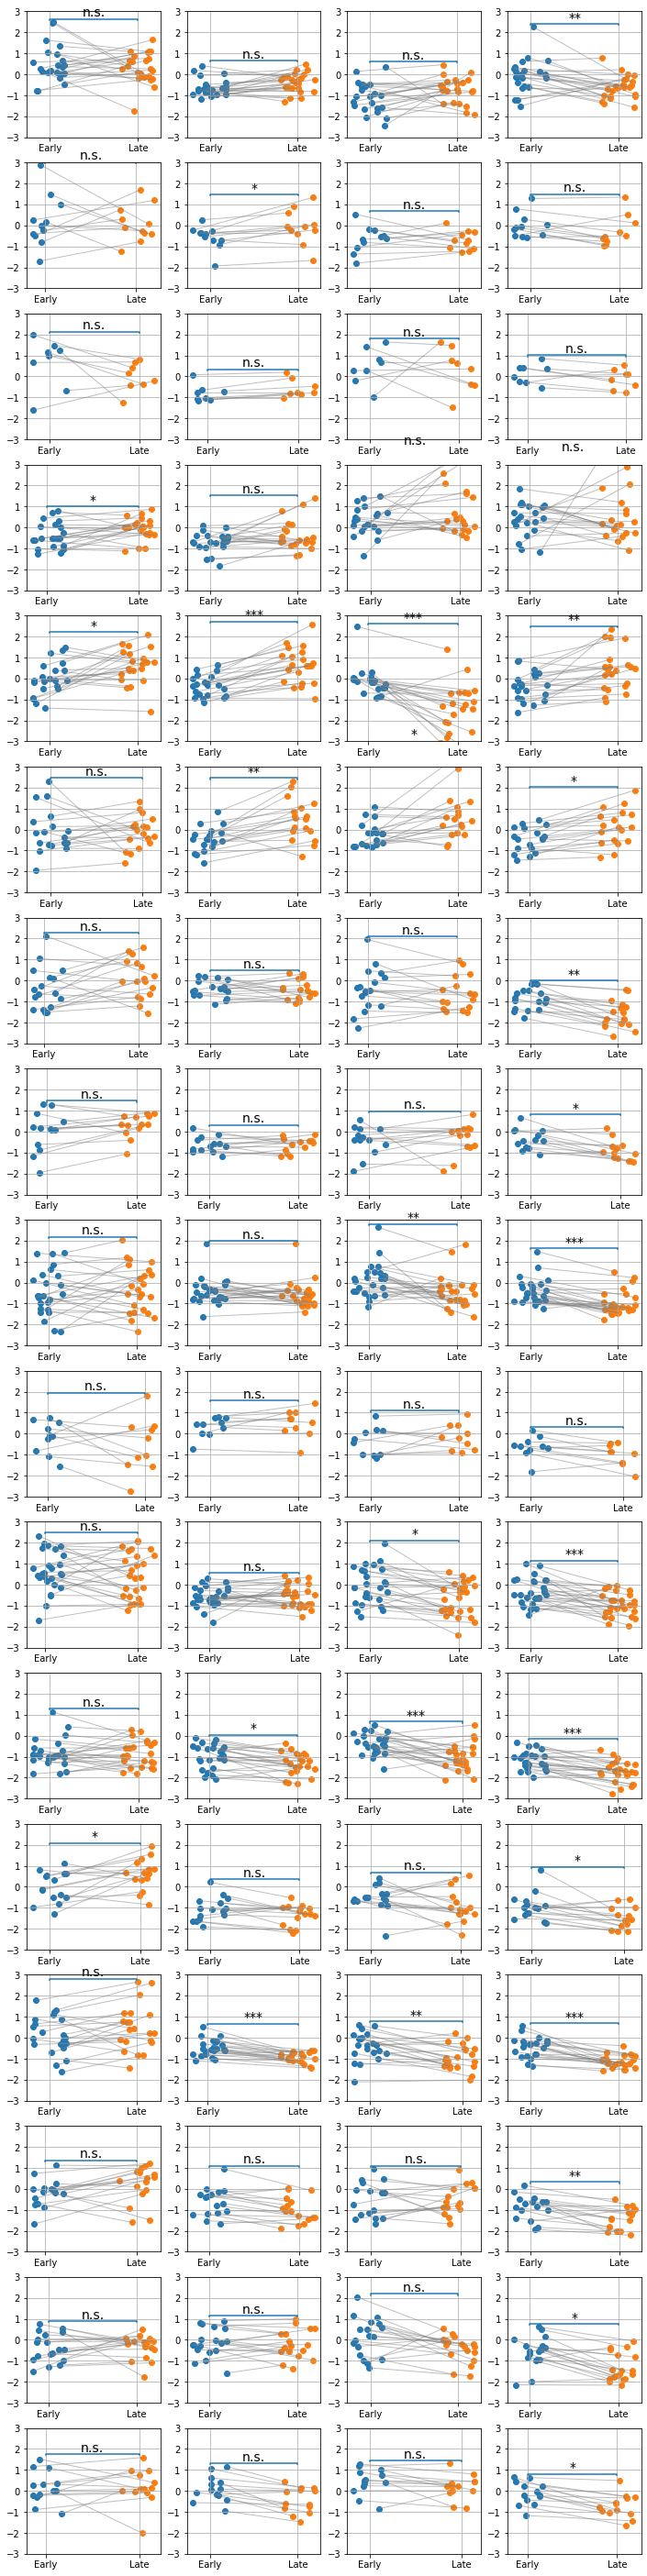

In [49]:
phase_count = 4
rows = len(selected)
cols = phase_count

fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

for i, session in enumerate(selected):

    for phase in range(phase_count):
        ax = axes[i][phase]
        state_early = s_stats[i][0]
        state_late  = s_stats[i][1]
        
        x_vals_early = 1*np.ones(len(state_early)) + (np.random.rand(len(state_early)) - 0.5)*0.4
        x_vals_late  = 2*np.ones(len(state_late)) + (np.random.rand(len(state_late)) - 0.5)*0.4
        for k in range(len(state_early)):
            ax.plot([x_vals_early[k], x_vals_late[k]], [state_early[k][phase], state_late[k][phase]], color='gray', lw=1, alpha=0.5)
        ax.scatter(x_vals_early, state_early[:, phase])
        ax.scatter(x_vals_late,  state_late[:, phase])

        # stats
        _, pval = stats.mannwhitneyu(state_early[:, phase], state_late[:, phase])
        x1, x2 = 1, 2
        y, h = np.concatenate([state_early[:, phase], state_late[:, phase]]).max() + 0.1, 0.05

        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5)
        ax.text((x1+x2)*.5, y+h, get_asterisks(pval), ha='center', va='bottom', fontsize=14)
        ax.set_ylim(-3, 3)
        ax.set_xticks([1, 2])
        ax.set_xticklabels(['Early', 'Late'])
        ax.grid()
        if j == 0:
            ax.set_ylabel(session[-19:-6], fontsize=14)


## Cross-session

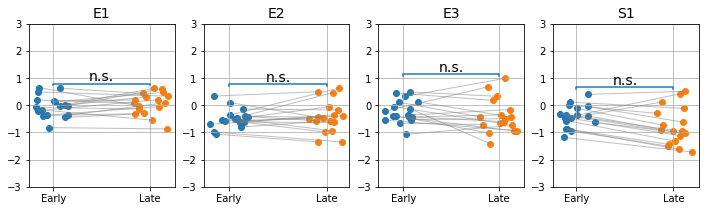

In [50]:
phase_count = 4
rows = 1
cols = phase_count
titles = ['E1', 'E2', 'E3', 'S1']

fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

for phase in range(phase_count):
    ax = axes[phase]
    state_early_means = np.array([s_stats[i][0][:, phase].mean() for i, s in enumerate(selected)])
    state_late_means  = np.array([s_stats[i][1][:, phase].mean() for i, s in enumerate(selected)])

    x_vals_early = 1*np.ones(len(state_early_means)) + (np.random.rand(len(state_early_means)) - 0.5)*0.4
    x_vals_late  = 2*np.ones(len(state_late_means)) + (np.random.rand(len(state_late_means)) - 0.5)*0.4
    for k in range(len(state_early_means)):
        ax.plot([x_vals_early[k], x_vals_late[k]], [state_early_means[k], state_late_means[k]], color='gray', lw=1, alpha=0.5)
    ax.scatter(x_vals_early, state_early_means)
    ax.scatter(x_vals_late,  state_late_means)

    # stats
    _, pval = stats.mannwhitneyu(state_early_means, state_late_means)
    x1, x2 = 1, 2
    y, h = np.concatenate([state_early_means, state_late_means]).max() + 0.1, 0.05

    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5)
    ax.text((x1+x2)*.5, y+h, get_asterisks(pval), ha='center', va='bottom', fontsize=14)
    ax.set_ylim(-3, 3)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Early', 'Late'])
    ax.grid()
    ax.set_title(titles[phase], fontsize=14)